# MIS 284N Text Analysis Assignment 3

*Siqi Chen, Joshua Larky, Jiayan Lu, Jinru Su, Korawat Tanwisuth*

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import operator
import numpy as np
import math
import string
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
%matplotlib inline

## Task A

In [2]:
scores = pd.read_csv("Assignment 3 Sentiment Scores.csv")
model_list = scores.columns

In [3]:
for com in combinations(model_list, 2):
    scores[com[0]+'-'+com[1]]= scores[com[0]] - scores[com[1]]

In [4]:
sentiments = scores.drop(model_list, axis=1)
comparisons = sentiments.columns
G = nx.DiGraph()
for com in comparisons:
    pos_mean = sentiments[com][sentiments[com]>0].mean()
    neg_mean = sentiments[com][sentiments[com]<0].mean()
    b1 = com.split('-')[0]
    b2 = com.split('-')[1]
    if pd.notnull(pos_mean):
        G.add_edge(b2, b1, weight = round(pos_mean,1))
    if pd.notnull(neg_mean):
        G.add_edge(b1, b2, weight = round(abs(neg_mean), 1))

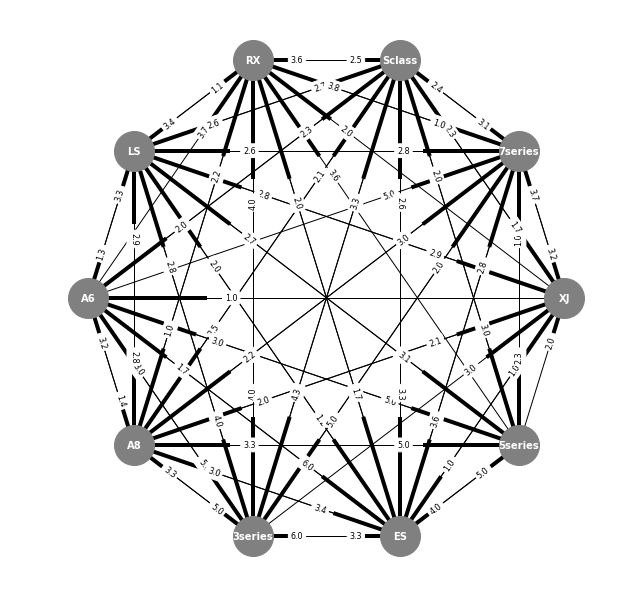

In [5]:
plt.figure(figsize = (8,8))
pos = nx.circular_layout(G)
nx.draw_circular(G)
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,label_pos=0.3, font_size=8)
nx.draw_networkx_labels(G, pos,font_size = 10,font_color='white', font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color = 'grey', node_size= 1600);

## Task B

### Unweighted Page Rank:

In [6]:
pagerank = pd.DataFrame(nx.pagerank(G,alpha=0.99,weight=1).items(),columns=['model','pagerank'])
pagerank.sort_values(by = 'pagerank', ascending= False)

,model,pagerank
1,Sclass,0.112149
4,LS,0.112149
6,A8,0.112149
8,ES,0.112149
2,7series,0.110777
3,RX,0.106855
7,3series,0.091943
0,XJ,0.084629
5,A6,0.082888
9,5series,0.074312


### Weighted Page Rank:

In [7]:
pagerank_w = pd.DataFrame(nx.pagerank(G,alpha=0.99).items(),columns=['model','pagerank_w'])
pagerank_w.sort_values(by = 'pagerank_w', ascending= False)

,model,pagerank_w
7,3series,0.141771
4,LS,0.112944
8,ES,0.110988
3,RX,0.106054
1,Sclass,0.104129
2,7series,0.100674
6,A8,0.098550
9,5series,0.086230
0,XJ,0.071479
5,A6,0.067181


### Correlation with 2012-2013 US sales:

In [8]:
sales = {'A6':20,'A8':12,'3series':220,'5series':60,'7series':14,'XJ':6.6,'ES':135,'LS':30,'RX':120,'Sclass':25}
sales = pd.DataFrame(sales.items(), columns=['model', 'sales'])

In [9]:
merged = pagerank_w.merge(pagerank).merge(sales)
merged 

,model,pagerank_w,pagerank,sales
0,XJ,0.071479,0.084629,6.6
1,Sclass,0.104129,0.112149,25.0
2,7series,0.100674,0.110777,14.0
3,RX,0.106054,0.106855,120.0
4,LS,0.112944,0.112149,30.0
5,A6,0.067181,0.082888,20.0
6,A8,0.098550,0.112149,12.0
7,3series,0.141771,0.091943,220.0
8,ES,0.110988,0.112149,135.0
9,5series,0.086230,0.074312,60.0


In [10]:
print 'Correlation between unweighted PageRank and sales:', merged.pagerank.corr(merged.sales)
print 'Correlation between weighted PageRank and sales:', merged.pagerank_w.corr(merged.sales)

Correlation between unweighted PageRank and sales: -0.0344702488028
Correlation between weighted PageRank and sales: 0.740296163367


Weighted PageRank captures not only the direction of people's preference, but also the degree of preference (sentiment scores). Larger share of rank value will be assigned to model with stronger preference (edge with higher weight).

## Task C
In the file, header in 'Sheet 3' should be changed to 'Review'.

In [11]:
review = pd.DataFrame()
sheets = ['Sheet{}'.format(x) for x in range(1,7)]
for s in sheets:
    df = pd.read_excel('Edmunds Reviews.xlsx', sheetname = s)
    review = review.append(df,ignore_index=True)
review = review.drop_duplicates()

In [12]:
replace_list = [('lexuses','es'),('es350','es'),('es330','es'),('es300','es'),
                ('lexusls','ls'),('ls460','ls'),('ls430','ls'),('ls400','ls'),('ls500','ls'),
                ('lexusrx','rx'),('rx300','rx'),('rx350','rx'), ('rx450h','rx'),
                ('audia8','a8'),('audi-a8','a8'),('audia6','a6'),('audi-a6','a6'),
                ('bmw330i','3series'),('bmw320i','3series'),('bmw325i','3series'),('bmw340i','3series'),
                ('bmw530i','5series'),('bmw530e','5series'),('bmw535i','5series'),('bmw550i','5series'),
                ('bmw740i','7series'),('bmw745i','7series'),('bmw750i','7series'),('bmw760i','7series'),
                ('s-class','sclass'),
                ('xjr','xj'),('xjl','xj')]
replace_dist = dict(replace_list)

In [13]:
#replace model name
def model_replace(review):
    for key in replace_dist:
        review = review.replace(key,replace_dist[key])
    return review

review['Review']= review['Review'].apply(lambda x: x.lower())
review['Review'] = review['Review'].apply(model_replace)
#tokenize, not removing stopwords bcuz can affect sentiment 
review['word'] = review['Review'].apply(lambda x: word_tokenize(x))

In [14]:
model = map(lambda x:x.lower(),model_list)

In [15]:
analyzer = SentimentIntensityAnalyzer()

score_auto = []

for row in review.word:
    score_dict = {}
    for m in model:
        loc = [i for i, j in enumerate(row) if j == m]
        if loc != []:
            score = []
            for l in loc:
                sent = ' '.join(row[x] for x in range(max(l - 8,0), min(l + 8,len(row))))
                score.append(analyzer.polarity_scores(sent)['compound'] * 5.0)
            m_score = np.mean(score)
            score_dict[m] = m_score
        else:
            continue
    score_auto.append(score_dict)
score_auto = pd.DataFrame(score_auto)


In [16]:
score_auto

,3series,5series,7series,a6,a8,es,ls,rx,sclass,xj
0,NaN,NaN,NaN,NaN,NaN,0.000000,0.903000,0.000000,NaN,NaN
1,NaN,NaN,0.000000,NaN,1.191750,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.0000,0.000000,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0000,0.000000,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0.513500,0.000000,NaN,NaN,NaN,NaN
5,NaN,NaN,-1.224500,NaN,-0.386000,-0.193500,0.256750,NaN,0.00000,NaN
6,0.0000,NaN,2.202000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.8060,1.701500,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,2.786750,NaN,1.80600,NaN
9,NaN,NaN,NaN,NaN,0.363667,NaN,NaN,NaN,0.00000,NaN


In [17]:
for com in combinations(model, 2):
    score_auto[com[0]+'-'+com[1]]= score_auto[com[0]] - score_auto[com[1]]    

In [18]:
sentiments = score_auto.drop(model, axis=1)
comparisons = sentiments.columns
G = nx.DiGraph()
for com in comparisons:
    pos_mean = sentiments[com][sentiments[com]>0].mean()
    neg_mean = sentiments[com][sentiments[com]<0].mean()
    b1 = com.split('-')[0]
    b2 = com.split('-')[1]
    if pd.notnull(pos_mean):
        G.add_edge(b2, b1, weight = round(pos_mean,1))
    if pd.notnull(neg_mean):
        G.add_edge(b1, b2, weight = round(abs(neg_mean), 1))

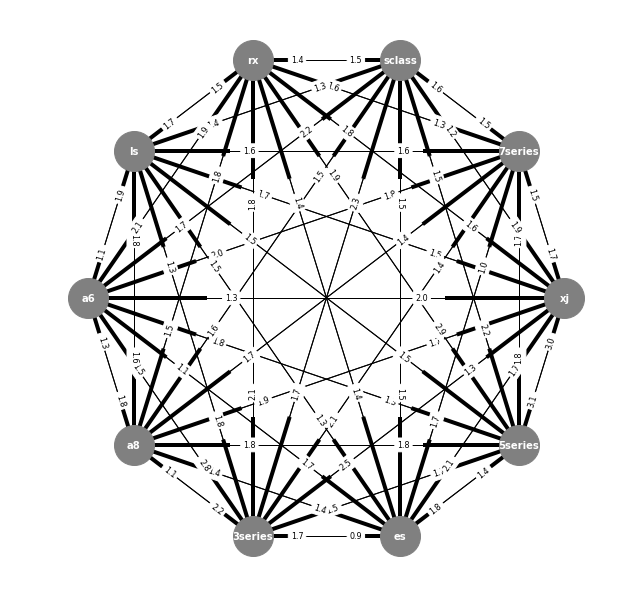

In [19]:
plt.figure(figsize = (8,8))
pos = nx.circular_layout(G)
nx.draw_circular(G)
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,label_pos=0.3, font_size=8)
nx.draw_networkx_labels(G, pos,font_size = 10,font_color='white', font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color = 'grey', node_size= 1600);

In [20]:
pagerank_auto = pd.DataFrame(nx.pagerank(G,alpha=0.99).items(),columns = ['model','pagerank'])

In [21]:
pagerank_auto.sort_values(by = 'pagerank', ascending= False)

,model,pagerank
7,3series,0.116204
9,5series,0.116078
0,xj,0.108630
3,rx,0.100887
2,sclass,0.097852
6,a8,0.094765
4,ls,0.093834
5,a6,0.093493
8,es,0.089434
1,7series,0.088822


In [22]:
sales['model'] = sales['model'].apply(lambda x:x.lower())

In [21]:
merged_auto = pagerank_auto.merge(sales)
merged_auto

In [22]:
print 'Correlation between weighted page rank and sales:', merged_auto.pagerank.corr(merged_auto.sales)

Correlation between weighted page rank and sales: 0.407772591882


The correlation with weighted PageRank and sales using automated sentiment analyzer is lower than manual scoring. Using proximity to determine the sentiment associate with each model mention potentially reduces the accuracy of sentiment score.